# Mean-variance optimization

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cp
import collections
from collections.abc import Iterable
from sklearn import covariance
from typing import List
import copy

In [1]:
!pip3 install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 2.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"]

In [3]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  15 of 15 completed


In [4]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2023-08-01,320.970001,131.690002,555.469971,89.029999,13.42,75.680000,157.179993,61.770000,33.430000,397.070007,336.339996,35.610001,261.070007,504.739990,106.620003
2023-08-02,317.779999,128.210007,552.349976,86.300003,13.04,75.680000,155.399994,61.959999,33.369999,390.019989,327.500000,35.349998,254.110001,504.799988,105.290001
2023-08-03,317.130005,128.910004,557.690002,85.489998,13.10,75.529999,156.350006,61.639999,32.259998,393.010010,326.660004,35.000000,259.320007,504.859985,107.120003
2023-08-04,312.000000,139.570007,552.039978,86.300003,12.89,78.680000,156.020004,60.709999,32.730000,391.350006,327.779999,35.020000,253.860001,502.730011,107.419998
2023-08-07,315.869995,142.220001,558.409973,86.830002,12.94,80.669998,156.759995,61.189999,32.970001,396.869995,330.109985,35.680000,251.449997,510.739990,107.199997


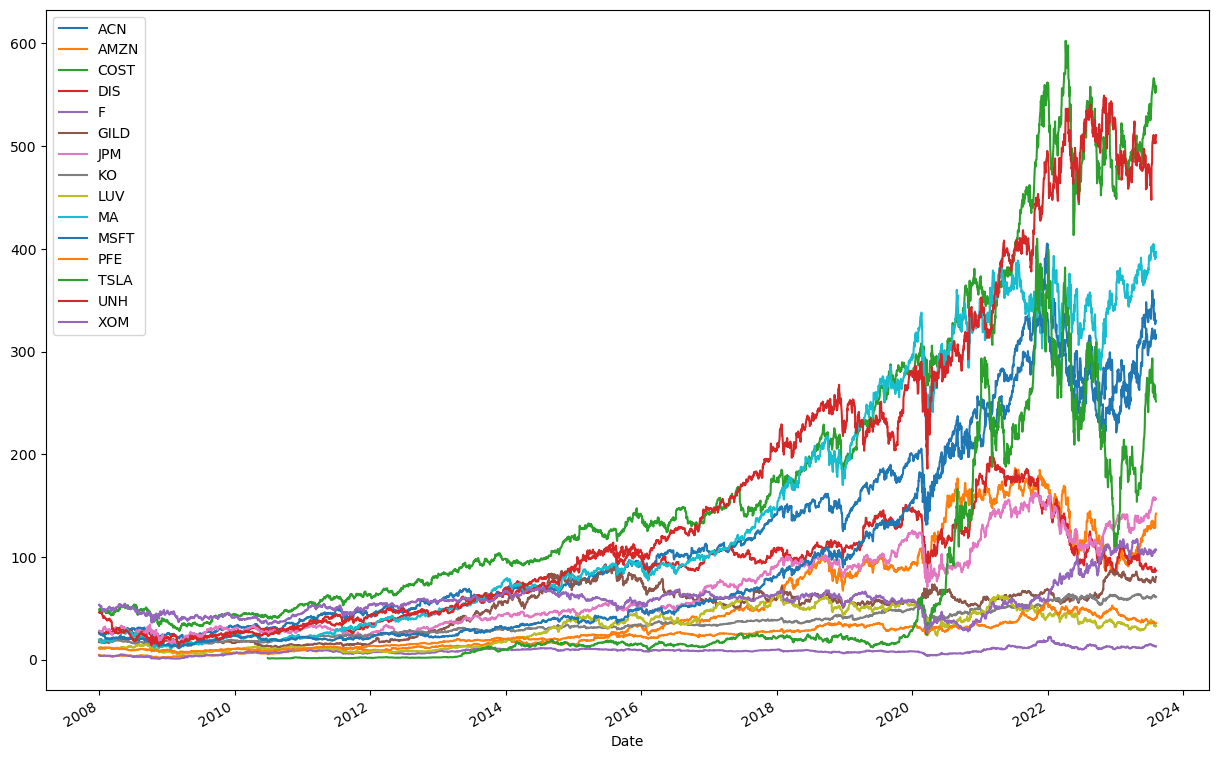

In [5]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10))

# Calculating the covariance matrix


In [54]:
'''risk Models'''
def sample_cov(prices, returns_data=False, frequency=252, log_returns=False, **kwargs):
    """Calculate the annualised sample covariance matrix of (daily) asset returns"""
    if not isinstance(prices, pd.DataFrame):
        warnings.warn("data is not in a dataframe", RuntimeWarning)
        prices = pd.DataFrame(prices)
    if returns_data:
        returns = prices
    else:
        returns = returns_from_prices(prices, log_returns)
    return fix_nonpositive_semidefinite(
        returns.cov() * frequency, kwargs.get("fix_method", "spectral")
    )

def fix_nonpositive_semidefinite(matrix, fix_method="spectral"):
    """Check if a covariance matrix is positive semidefinite, and if not, fix it
    with the chosen method.

    The ``spectral`` method sets negative eigenvalues to zero then rebuilds the matrix,
    while the ``diag`` method adds a small positive value to the diagonal"""
    if _is_positive_semidefinite(matrix):
        return matrix

    warnings.warn(
        "The covariance matrix is non positive semidefinite. Amending eigenvalues."
    )

    # Eigendecomposition
    q, V = np.linalg.eigh(matrix)

    if fix_method == "spectral":
        # Remove negative eigenvalues
        q = np.where(q > 0, q, 0)
        # Reconstruct matrix
        fixed_matrix = V @ np.diag(q) @ V.T
    elif fix_method == "diag":
        min_eig = np.min(q)
        fixed_matrix = matrix - 1.1 * min_eig * np.eye(len(matrix))
    else:
        raise NotImplementedError("Method {} not implemented".format(fix_method))

    if not _is_positive_semidefinite(fixed_matrix):  # pragma: no cover
        warnings.warn(
            "Could not fix matrix. Please try a different risk model.", UserWarning
        )

    # Rebuild labels if provided
    if isinstance(matrix, pd.DataFrame):
        tickers = matrix.index
        return pd.DataFrame(fixed_matrix, index=tickers, columns=tickers)
    else:
        return fixed_matrix

def _is_positive_semidefinite(matrix):
    """Helper function to check if a given matrix is positive semidefinite.
    Any method that requires inverting the covariance matrix will struggle
    with a non-positive semidefinite matrix"""
    try:
        # Significantly more efficient than checking eigenvalues (stackoverflow.com/questions/16266720)
        np.linalg.cholesky(matrix + 1e-16 * np.eye(len(matrix)))
        return True
    except np.linalg.LinAlgError:
        return False

def cov_to_corr(cov_matrix):
    """Convert a covariance matrix to a correlation matrix"""
    if not isinstance(cov_matrix, pd.DataFrame):
        warnings.warn("cov_matrix is not a dataframe", RuntimeWarning)
        cov_matrix = pd.DataFrame(cov_matrix)

    Dinv = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
    corr = np.dot(Dinv, np.dot(cov_matrix, Dinv))
    return pd.DataFrame(corr, index=cov_matrix.index, columns=cov_matrix.index)

def semicovariance(
    prices,
    returns_data=False,
    benchmark=0.000079,
    frequency=252,
    log_returns=False,
    **kwargs
):
    """Estimate the semicovariance matrix, i.e the covariance given that
    the returns are less than the benchmark"""
    if not isinstance(prices, pd.DataFrame):
        warnings.warn("data is not in a dataframe", RuntimeWarning)
        prices = pd.DataFrame(prices)
    if returns_data:
        returns = prices
    else:
        returns = returns_from_prices(prices, log_returns)
    drops = np.fmin(returns - benchmark, 0)
    T = drops.shape[0]
    return fix_nonpositive_semidefinite(
        (drops.T @ drops) / T * frequency, kwargs.get("fix_method", "spectral")
    )


class CovarianceShrinkage:
    """Provide methods for computing shrinkage estimates of the covariance matrix, using the
    sample covariance matrix and choosing the structured estimator to be an identity matrix
    multiplied by the average sample variance"""

    def __init__(self, prices, returns_data=False, frequency=252, log_returns=False):
        # Optional import
        try:
            from sklearn import covariance

            self.covariance = covariance
        except (ModuleNotFoundError, ImportError):  # pragma: no cover
            raise ImportError("Please install scikit-learn via pip or poetry")

        if not isinstance(prices, pd.DataFrame):
            warnings.warn("data is not in a dataframe", RuntimeWarning)
            prices = pd.DataFrame(prices)

        self.frequency = frequency

        if returns_data:
            self.X = prices.dropna(how="all")
        else:
            self.X = returns_from_prices(prices, log_returns).dropna(how="all")

        self.S = self.X.cov().values
        self.delta = None  # shrinkage constant

    def _format_and_annualize(self, raw_cov_array):
        """Helper method which annualises the output of shrinkage calculations,
        and formats the result into a dataframe"""
        assets = self.X.columns
        cov = pd.DataFrame(raw_cov_array, index=assets, columns=assets) * self.frequency
        return fix_nonpositive_semidefinite(cov, fix_method="spectral")

    def shrunk_covariance(self, delta=0.2):
        """Shrink a sample covariance matrix to the identity matrix (scaled by the average
        sample variance). This method does not estimate an optimal shrinkage parameter,
        it requires manual input"""
        self.delta = delta
        N = self.S.shape[1]
        # Shrinkage target
        mu = np.trace(self.S) / N
        F = np.identity(N) * mu
        # Shrinkage
        shrunk_cov = delta * F + (1 - delta) * self.S
        return self._format_and_annualize(shrunk_cov)

    def ledoit_wolf(self, shrinkage_target="constant_variance"):
        """Calculate the Ledoit-Wolf shrinkage estimate for a particular
        shrinkage target"""
        if shrinkage_target == "constant_variance":
            X = np.nan_to_num(self.X.values)
            shrunk_cov, self.delta = self.covariance.ledoit_wolf(X)
        elif shrinkage_target == "single_factor":
            shrunk_cov, self.delta = self._ledoit_wolf_single_factor()
        elif shrinkage_target == "constant_correlation":
            shrunk_cov, self.delta = self._ledoit_wolf_constant_correlation()
        else:
            raise NotImplementedError(
                "Shrinkage target {} not recognised".format(shrinkage_target)
            )

        return self._format_and_annualize(shrunk_cov)

    def _ledoit_wolf_single_factor(self):
        """Helper method to calculate the Ledoit-Wolf shrinkage estimate
        with the Sharpe single-factor matrix as the shrinkage target"""
        X = np.nan_to_num(self.X.values)

        # De-mean returns
        t, n = np.shape(X)
        Xm = X - X.mean(axis=0)
        xmkt = Xm.mean(axis=1).reshape(t, 1)

        # compute sample covariance matrix
        sample = np.cov(np.append(Xm, xmkt, axis=1), rowvar=False) * (t - 1) / t
        betas = sample[0:n, n].reshape(n, 1)
        varmkt = sample[n, n]
        sample = sample[:n, :n]
        F = np.dot(betas, betas.T) / varmkt
        F[np.eye(n) == 1] = np.diag(sample)

        # compute shrinkage parameters
        c = np.linalg.norm(sample - F, "fro") ** 2
        y = Xm**2
        p = 1 / t * np.sum(np.dot(y.T, y)) - np.sum(sample**2)

        # r is divided into diagonal
        # and off-diagonal terms, and the off-diagonal term
        # is itself divided into smaller terms
        rdiag = 1 / t * np.sum(y**2) - sum(np.diag(sample) ** 2)
        z = Xm * np.tile(xmkt, (n,))
        v1 = 1 / t * np.dot(y.T, z) - np.tile(betas, (n,)) * sample
        roff1 = (
            np.sum(v1 * np.tile(betas, (n,)).T) / varmkt
            - np.sum(np.diag(v1) * betas.T) / varmkt
        )
        v3 = 1 / t * np.dot(z.T, z) - varmkt * sample
        roff3 = (
            np.sum(v3 * np.dot(betas, betas.T)) / varmkt**2
            - np.sum(np.diag(v3).reshape(-1, 1) * betas**2) / varmkt**2
        )
        roff = 2 * roff1 - roff3
        r = rdiag + roff

        # compute shrinkage constant
        k = (p - r) / c
        delta = max(0, min(1, k / t))

        # compute the estimator
        shrunk_cov = delta * F + (1 - delta) * sample
        return shrunk_cov, delta

    def _ledoit_wolf_constant_correlation(self):
        """Helper method to calculate the Ledoit-Wolf shrinkage estimate
        with the constant correlation matrix as the shrinkage target"""
        X = np.nan_to_num(self.X.values)
        t, n = np.shape(X)

        S = self.S  # sample cov matrix

        # Constant correlation target
        var = np.diag(S).reshape(-1, 1)
        std = np.sqrt(var)
        _var = np.tile(var, (n,))
        _std = np.tile(std, (n,))
        r_bar = (np.sum(S / (_std * _std.T)) - n) / (n * (n - 1))
        F = r_bar * (_std * _std.T)
        F[np.eye(n) == 1] = var.reshape(-1)

        # Estimate pi
        Xm = X - X.mean(axis=0)
        y = Xm**2
        pi_mat = np.dot(y.T, y) / t - 2 * np.dot(Xm.T, Xm) * S / t + S**2
        pi_hat = np.sum(pi_mat)

        # Theta matrix, expanded term by term
        term1 = np.dot((Xm**3).T, Xm) / t
        help_ = np.dot(Xm.T, Xm) / t
        help_diag = np.diag(help_)
        term2 = np.tile(help_diag, (n, 1)).T * S
        term3 = help_ * _var
        term4 = _var * S
        theta_mat = term1 - term2 - term3 + term4
        theta_mat[np.eye(n) == 1] = np.zeros(n)
        rho_hat = sum(np.diag(pi_mat)) + r_bar * np.sum(
            np.dot((1 / std), std.T) * theta_mat
        )

        # Estimate gamma
        gamma_hat = np.linalg.norm(S - F, "fro") ** 2

        # Compute shrinkage constant
        kappa_hat = (pi_hat - rho_hat) / gamma_hat
        delta = max(0.0, min(1.0, kappa_hat / t))

        # Compute shrunk covariance matrix
        shrunk_cov = delta * F + (1 - delta) * S
        return shrunk_cov, delta

    def oracle_approximating(self):
        """Calculate the Oracle Approximating Shrinkage estimate"""
        X = np.nan_to_num(self.X.values)
        shrunk_cov, self.delta = self.covariance.oas(X)
        return self._format_and_annualize(shrunk_cov)

In [55]:
'''Expected Returns'''
def returns_from_prices(prices, log_returns=False):
    """Calculate the returns given prices"""
    if log_returns:
        returns = np.log(1 + prices.pct_change()).dropna(how="all")
    else:
        returns = prices.pct_change().dropna(how="all")
    return returns

def capm_return(
    prices,
    market_prices=None,
    returns_data=False,
    risk_free_rate=0.02,
    compounding=True,
    frequency=252,
    log_returns=False,
):
    """Compute a return estimate using the Capital Asset Pricing Model"""
    if not isinstance(prices, pd.DataFrame):
        warnings.warn("prices are not in a dataframe", RuntimeWarning)
        prices = pd.DataFrame(prices)

    market_returns = None

    if returns_data:
        returns = prices.copy()
        if market_prices is not None:
            market_returns = market_prices
    else:
        returns = returns_from_prices(prices, log_returns)

        if market_prices is not None:
            if not isinstance(market_prices, pd.DataFrame):
                warnings.warn("market prices are not in a dataframe", RuntimeWarning)
                market_prices = pd.DataFrame(market_prices)

            market_returns = returns_from_prices(market_prices, log_returns)
    # Use the equally-weighted dataset as a proxy for the market
    if market_returns is None:
        # Append market return to right and compute sample covariance matrix
        returns["mkt"] = returns.mean(axis=1)
    else:
        market_returns.columns = ["mkt"]
        returns = returns.join(market_returns, how="left")

    _check_returns(returns)

    # Compute covariance matrix for the new dataframe (including markets)
    cov = returns.cov()
    # The far-right column of the cov matrix is covariances to market
    betas = cov["mkt"] / cov.loc["mkt", "mkt"]
    betas = betas.drop("mkt")
    # Find mean market return on a given time period
    if compounding:
        mkt_mean_ret = (1 + returns["mkt"]).prod() ** (
            frequency / returns["mkt"].count()
        ) - 1
    else:
        mkt_mean_ret = returns["mkt"].mean() * frequency

    # CAPM formula
    return risk_free_rate + betas * (mkt_mean_ret - risk_free_rate)

def _check_returns(returns):
    # Check NaNs excluding leading NaNs
    if np.any(np.isnan(returns.mask(returns.ffill().isnull(), 0))):
        warnings.warn(
            "Some returns are NaN. Please check your price data.", UserWarning
        )
    if np.any(np.isinf(returns)):
        warnings.warn(
            "Some returns are infinite. Please check your price data.", UserWarning
        )

In [56]:
sample_cov = sample_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
ACN,0.090323,0.046758,0.028410,0.041344,0.044707,0.028458,0.047826,0.020414,0.037016,0.045982,0.042257,0.025634,0.044449,0.029888,0.029933
AMZN,0.046758,0.325501,0.047831,0.056145,0.053505,0.056688,0.064988,0.020005,0.047626,0.056364,0.073008,0.030739,0.066563,0.033884,0.026374
COST,0.028410,0.047831,0.100309,0.031814,0.031778,0.026703,0.038051,0.021241,0.030966,0.032125,0.037315,0.025056,0.029469,0.027203,0.020169
DIS,0.041344,0.056145,0.031814,0.099666,0.041520,0.031784,0.047008,0.025977,0.039824,0.050388,0.042926,0.029126,0.043913,0.031461,0.025710
F,0.044707,0.053505,0.031778,0.041520,0.127870,0.029738,0.054522,0.026139,0.047104,0.061760,0.041694,0.026918,0.059825,0.028767,0.028214
GILD,0.028458,0.056688,0.026703,0.031784,0.029738,0.228454,0.041747,0.016663,0.030576,0.031563,0.034617,0.032257,0.030832,0.033441,0.020868
JPM,0.047826,0.064988,0.038051,0.047008,0.054522,0.041747,0.126835,0.027476,0.048796,0.067565,0.048606,0.032375,0.041166,0.038053,0.033061
KO,0.020414,0.020005,0.021241,0.025977,0.026139,0.016663,0.027476,0.053145,0.022710,0.025715,0.027518,0.025806,0.018195,0.022796,0.020483
LUV,0.037016,0.047626,0.030966,0.039824,0.047104,0.030576,0.048796,0.022710,0.138095,0.047883,0.036654,0.025662,0.043018,0.031836,0.023356
MA,0.045982,0.056364,0.032125,0.050388,0.061760,0.031563,0.067565,0.025715,0.047883,0.115082,0.049128,0.031346,0.048991,0.041275,0.040888


In [60]:
'''Plotting'''
def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """Generate a basic plot of the covariance (or correlation) matrix, given a
    covariance matrix"""
    if plot_correlation:
        matrix = cov_to_corr(cov_matrix)
    else:
        matrix = cov_matrix
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix)
    fig.colorbar(cax)

    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)
        plt.xticks(rotation=90)

    _plot_io(**kwargs)

    return ax

def _plot_io(**kwargs):
    """Helper method to optionally save the figure to file"""
    filename = kwargs.get("filename", None)
    showfig = kwargs.get("showfig", False)
    dpi = kwargs.get("dpi", 300)

    plt.tight_layout()
    if filename:
        plt.savefig(fname=filename, dpi=dpi)
    if showfig:  # pragma: no cover
        plt.show()

def plot_efficient_frontier(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    """Plot the efficient frontier based on either a CLA or EfficientFrontier object"""
    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax

def _plot_cla(cla, points, ax, show_assets, show_tickers):
    """Helper function to plot the efficient frontier from a CLA object"""
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance()

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    ax.plot(sigmas, mus, label="Efficient frontier")
    ax.scatter(optimal_risk, optimal_ret, marker="x", s=100, color="r", label="optimal")

    asset_mu = cla.expected_returns
    asset_sigma = np.sqrt(np.diag(cla.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(cla.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax

def _plot_ef(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """Helper function to plot the efficient frontier from an EfficientFrontier object"""
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax

def _ef_default_returns_range(ef, points):
    """Helper function to generate a range of returns from the GMV returns to
    the maximum (constrained) returns"""
    ef_minvol = ef.deepcopy()
    ef_maxret = ef.deepcopy()

    ef_minvol.min_volatility()
    min_ret = ef_minvol.portfolio_performance()[0]
    max_ret = ef_maxret._max_return()
    return np.linspace(min_ret, max_ret - 0.0001, points)

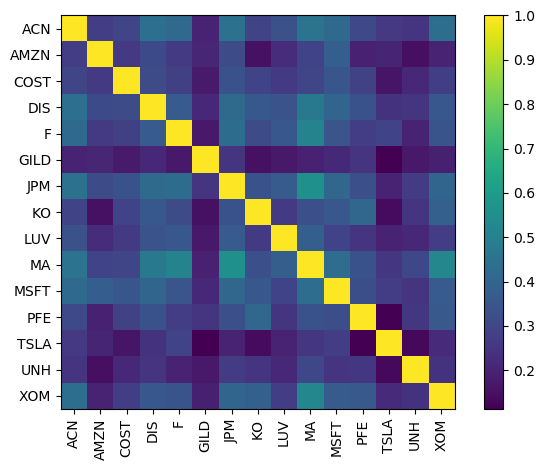

In [61]:
plot_covariance(sample_cov, plot_correlation=True)

## For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

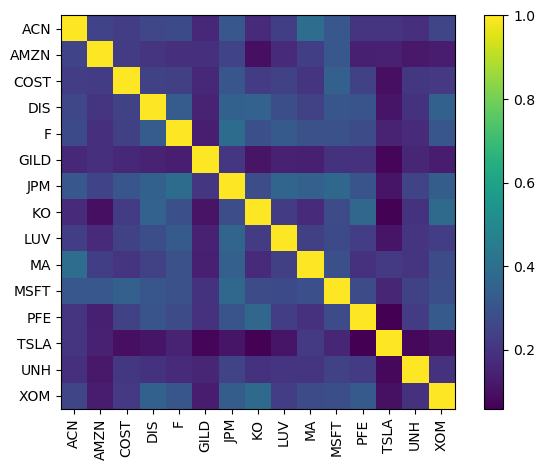

In [62]:
S = CovarianceShrinkage(prices).ledoit_wolf()
plot_covariance(S, plot_correlation=True)

# Return estimation

## As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the min_volatility() portfolio or use HRP.

## However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook 1-RiskReturnModels.ipynb for more information.


In [63]:
mu = capm_return(prices)
mu

ACN     0.207240
AMZN    0.347859
COST    0.190736
DIS     0.220552
F       0.223131
GILD    0.243960
JPM     0.245603
KO      0.144836
LUV     0.223447
MA      0.253596
MSFT    0.234815
PFE     0.173633
TSLA    0.293212
UNH     0.213139
XOM     0.139205
Name: mkt, dtype: float64

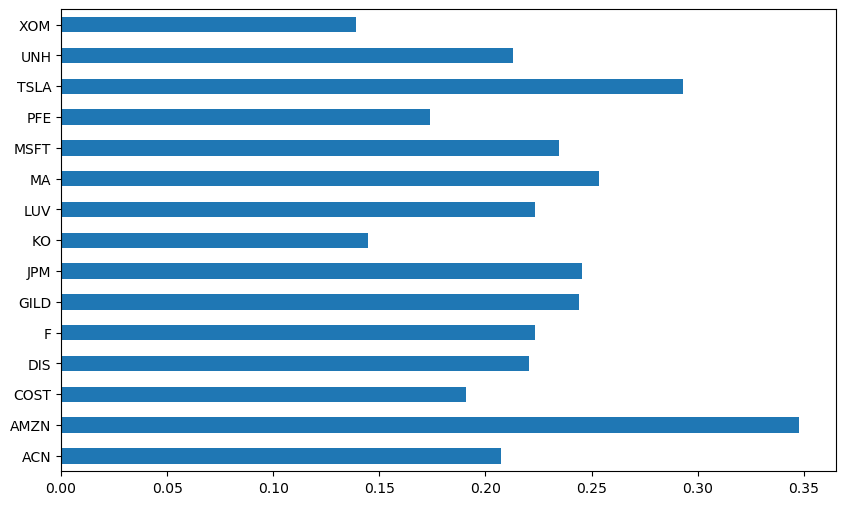

In [64]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

## In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.


In [65]:
'''Base Optimizer'''
class BaseOptimizer:

    def __init__(self, n_assets, tickers=None):
        """
        :param n_assets: number of assets
        :type n_assets: int
        :param tickers: name of assets
        :type tickers: list
        """
        self.n_assets = n_assets
        if tickers is None:
            self.tickers = list(range(n_assets))
        else:
            self.tickers = tickers
        self._risk_free_rate = None
        # Outputs
        self.weights = None

    def _make_output_weights(self, weights=None):
        """
        Utility function to make output weight dict from weight attribute (np.array). If no
        arguments passed, use self.tickers and self.weights. If one argument is passed, assume
        it is an alternative weight array so use self.tickers and the argument.
        """
        if weights is None:
            weights = self.weights

        return collections.OrderedDict(zip(self.tickers, weights))

    def set_weights(self, input_weights):
        """
        Utility function to set weights attribute (np.array) from user input

        :param input_weights: {ticker: weight} dict
        :type input_weights: dict
        """
        self.weights = np.array([input_weights[ticker] for ticker in self.tickers])

    def clean_weights(self, cutoff=1e-4, rounding=5):
        """
        Helper method to clean the raw weights, setting any weights whose absolute
        values are below the cutoff to zero, and rounding the rest"""
        if self.weights is None:
            raise AttributeError("Weights not yet computed")
        clean_weights = self.weights.copy()
        clean_weights[np.abs(clean_weights) < cutoff] = 0
        if rounding is not None:
            if not isinstance(rounding, int) or rounding < 1:
                raise ValueError("rounding must be a positive integer")
            clean_weights = np.round(clean_weights, rounding)

        return self._make_output_weights(clean_weights)

    def save_weights_to_file(self, filename="weights.csv"):
        """Utility method to save weights to a text file"""
        clean_weights = self.clean_weights()

        ext = filename.split(".")[1]
        if ext == "csv":
            pd.Series(clean_weights).to_csv(filename, header=False)
        elif ext == "json":
            with open(filename, "w") as fp:
                json.dump(clean_weights, fp)
        elif ext == "txt":
            with open(filename, "w") as f:
                f.write(str(dict(clean_weights)))
        else:
            raise NotImplementedError("Only supports .txt .json .csv")




class BaseConvexOptimizer(BaseOptimizer):
    def __init__(
        self,
        n_assets,
        tickers=None,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):
        super().__init__(n_assets, tickers)

        # Optimization variables
        self._w = cp.Variable(n_assets)
        self._objective = None
        self._additional_objectives = []
        self._constraints = []
        self._lower_bounds = None
        self._upper_bounds = None
        self._opt = None
        self._solver = solver
        self._verbose = verbose
        self._solver_options = solver_options if solver_options else {}
        self._map_bounds_to_constraints(weight_bounds)

    def deepcopy(self):
        self_copy = copy.copy(self)
        self_copy._additional_objectives = [
            copy.copy(obj) for obj in self_copy._additional_objectives
        ]
        self_copy._constraints = [copy.copy(con) for con in self_copy._constraints]
        return self_copy

    def _map_bounds_to_constraints(self, test_bounds):
        # If it is a collection with the right length, assume they are all bounds.
        if len(test_bounds) == self.n_assets and not isinstance(
            test_bounds[0], (float, int)
        ):
            bounds = np.array(test_bounds, dtype=float)
            self._lower_bounds = np.nan_to_num(bounds[:, 0], nan=-np.inf)
            self._upper_bounds = np.nan_to_num(bounds[:, 1], nan=np.inf)
        else:
            # Otherwise this must be a pair.
            if len(test_bounds) != 2 or not isinstance(test_bounds, (tuple, list)):
                raise TypeError(
                    "test_bounds must be a pair (lower bound, upper bound) OR a collection of bounds for each asset"
                )
            lower, upper = test_bounds

            # Replace None values with the appropriate +/- 1
            if np.isscalar(lower) or lower is None:
                lower = -1 if lower is None else lower
                self._lower_bounds = np.array([lower] * self.n_assets)
                upper = 1 if upper is None else upper
                self._upper_bounds = np.array([upper] * self.n_assets)
            else:
                self._lower_bounds = np.nan_to_num(lower, nan=-1)
                self._upper_bounds = np.nan_to_num(upper, nan=1)

        self.add_constraint(lambda w: w >= self._lower_bounds)
        self.add_constraint(lambda w: w <= self._upper_bounds)

    def is_parameter_defined(self, parameter_name: str) -> bool:
        is_defined = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name and not is_defined:
                    is_defined = True
                elif param.name() == parameter_name and is_defined:
                    raise exceptions.InstantiationError(
                        "Parameter name defined multiple times"
                    )
        return is_defined

    def update_parameter_value(self, parameter_name: str, new_value: float) -> None:
        if not self.is_parameter_defined(parameter_name):
            raise exceptions.InstantiationError("Parameter has not been defined")
        was_updated = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name:
                    param.value = new_value
                    was_updated = True
        if not was_updated:
            raise exceptions.InstantiationError("Parameter was not updated")

    def _solve_cvxpy_opt_problem(self):
        try:
            if self._opt is None:
                self._opt = cp.Problem(cp.Minimize(self._objective), self._constraints)
                self._initial_objective = self._objective.id
                self._initial_constraint_ids = {const.id for const in self._constraints}
            else:
                if not self._objective.id == self._initial_objective:
                    raise exceptions.InstantiationError(
                        "The objective function was changed after the initial optimization. "
                        "Please create a new instance instead."
                    )

                constr_ids = {const.id for const in self._constraints}
                if not constr_ids == self._initial_constraint_ids:
                    raise exceptions.InstantiationError(
                        "The constraints were changed after the initial optimization. "
                        "Please create a new instance instead."
                    )
            self._opt.solve(
                solver=self._solver, verbose=self._verbose, **self._solver_options
            )

        except (TypeError, cp.DCPError) as e:
            raise exceptions.OptimizationError from e

        if self._opt.status not in {"optimal", "optimal_inaccurate"}:
            raise exceptions.OptimizationError(
                "Solver status: {}".format(self._opt.status)
            )
        self.weights = self._w.value.round(16) + 0.0  # +0.0 removes signed zero
        return self._make_output_weights()

    def add_objective(self, new_objective, **kwargs):
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding objectives to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of objectives."
            )
        self._additional_objectives.append(new_objective(self._w, **kwargs))

    def add_constraint(self, new_constraint):
        if not callable(new_constraint):
            raise TypeError(
                "New constraint must be provided as a callable (e.g lambda function)"
            )
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding constraints to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of constraints."
            )
        self._constraints.append(new_constraint(self._w))

    def add_sector_constraints(self, sector_mapper, sector_lower, sector_upper):
        if np.any(self._lower_bounds < 0):
            warnings.warn(
                "Sector constraints may not produce reasonable results if shorts are allowed."
            )
        for sector in sector_upper:
            is_sector = [sector_mapper.get(t) == sector for t in self.tickers]
            self.add_constraint(lambda w: cp.sum(w[is_sector]) <= sector_upper[sector])
        for sector in sector_lower:
            is_sector = [sector_mapper.get(t) == sector for t in self.tickers]
            self.add_constraint(lambda w: cp.sum(w[is_sector]) >= sector_lower[sector])

    def convex_objective(self, custom_objective, weights_sum_to_one=True, **kwargs):
        # custom_objective must have the right signature (w, **kwargs)
        self._objective = custom_objective(self._w, **kwargs)

        for obj in self._additional_objectives:
            self._objective += obj

        if weights_sum_to_one:
            self.add_constraint(lambda w: cp.sum(w) == 1)

        return self._solve_cvxpy_opt_problem()

    def nonconvex_objective(
        self,
        custom_objective,
        objective_args=None,
        weights_sum_to_one=True,
        constraints=None,
        solver="SLSQP",
        initial_guess=None,
    ):

        # Sanitise inputs
        if not isinstance(objective_args, tuple):
            objective_args = (objective_args,)

        # Make scipy bounds
        bound_array = np.vstack((self._lower_bounds, self._upper_bounds)).T
        bounds = list(map(tuple, bound_array))

        if initial_guess is None:
            initial_guess = np.array([1 / self.n_assets] * self.n_assets)

        # Construct constraints
        final_constraints = []
        if weights_sum_to_one:
            final_constraints.append({"type": "eq", "fun": lambda w: np.sum(w) - 1})
        if constraints is not None:
            final_constraints += constraints

        result = sco.minimize(
            custom_objective,
            x0=initial_guess,
            args=objective_args,
            method=solver,
            bounds=bounds,
            constraints=final_constraints,
        )
        self.weights = result["x"]
        return self._make_output_weights()

def portfolio_performance(
    weights, expected_returns, cov_matrix, verbose=False, risk_free_rate=0.02
):

    if isinstance(weights, dict):
        if isinstance(expected_returns, pd.Series):
            tickers = list(expected_returns.index)
        elif isinstance(cov_matrix, pd.DataFrame):
            tickers = list(cov_matrix.columns)
        else:
            tickers = list(range(len(expected_returns)))
        new_weights = np.zeros(len(tickers))

        for i, k in enumerate(tickers):
            if k in weights:
                new_weights[i] = weights[k]
        if new_weights.sum() == 0:
            raise ValueError("Weights add to zero, or ticker names don't match")
    elif weights is not None:
        new_weights = np.asarray(weights)
    else:
        raise ValueError("Weights is None")

    sigma = np.sqrt(portfolio_variance(new_weights, cov_matrix))

    if expected_returns is not None:
        mu = portfolio_return(
            new_weights, expected_returns, negative=False
        )

        sharpe = sharpe_ratio(
            new_weights,
            expected_returns,
            cov_matrix,
            risk_free_rate=risk_free_rate,
            negative=False,
        )
        if verbose:
            print("Expected annual return: {:.1f}%".format(100 * mu))
            print("Annual volatility: {:.1f}%".format(100 * sigma))
            print("Sharpe Ratio: {:.2f}".format(sharpe))
        return mu, sigma, sharpe
    else:
        if verbose:
            print("Annual volatility: {:.1f}%".format(100 * sigma))
        return None, sigma, None

def _get_all_args(expression: cp.Expression) -> List[cp.Expression]:

    if expression.args == []:
        return [expression]
    else:
        return list(_flatten([_get_all_args(arg) for arg in expression.args]))

def _flatten(alist: Iterable) -> Iterable:
    # Helper method to flatten an iterable
    for v in alist:
        if isinstance(v, Iterable) and not isinstance(v, (str, bytes)):
            yield from _flatten(v)
        else:
            yield v

In [66]:
'''Efficient Frontier'''
class EfficientFrontier(BaseConvexOptimizer):

    def __init__(
        self,
        expected_returns,
        cov_matrix,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):

        # Inputs
        self.cov_matrix = self._validate_cov_matrix(cov_matrix)
        self.expected_returns = self._validate_expected_returns(expected_returns)
        self._max_return_value = None
        self._market_neutral = None

        if self.expected_returns is None:
            num_assets = len(cov_matrix)
        else:
            num_assets = len(expected_returns)

        # Labels
        if isinstance(expected_returns, pd.Series):
            tickers = list(expected_returns.index)
        elif isinstance(cov_matrix, pd.DataFrame):
            tickers = list(cov_matrix.columns)
        else:  # use integer labels
            tickers = list(range(num_assets))

        if expected_returns is not None and cov_matrix is not None:
            if cov_matrix.shape != (num_assets, num_assets):
                raise ValueError("Covariance matrix does not match expected returns")

        super().__init__(
            len(tickers),
            tickers,
            weight_bounds,
            solver=solver,
            verbose=verbose,
            solver_options=solver_options,
        )

    @staticmethod
    def _validate_expected_returns(expected_returns):
        if expected_returns is None:
            return None
        elif isinstance(expected_returns, pd.Series):
            return expected_returns.values
        elif isinstance(expected_returns, list):
            return np.array(expected_returns)
        elif isinstance(expected_returns, np.ndarray):
            return expected_returns.ravel()
        else:
            raise TypeError("expected_returns is not a series, list or array")

    @staticmethod
    def _validate_cov_matrix(cov_matrix):
        if cov_matrix is None:
            raise ValueError("cov_matrix must be provided")
        elif isinstance(cov_matrix, pd.DataFrame):
            return cov_matrix.values
        elif isinstance(cov_matrix, np.ndarray):
            return cov_matrix
        else:
            raise TypeError("cov_matrix is not a dataframe or array")

    def _validate_returns(self, returns):
        """
        Helper method to validate daily returns (needed for some efficient frontiers)
        """
        if not isinstance(returns, (pd.DataFrame, np.ndarray)):
            raise TypeError("returns should be a pd.Dataframe or np.ndarray")

        returns_df = pd.DataFrame(returns)
        if returns_df.isnull().values.any():
            warnings.warn(
                "Removing NaNs from returns",
                UserWarning,
            )
            returns_df = returns_df.dropna(axis=0, how="any")

        if self.expected_returns is not None:
            if returns_df.shape[1] != len(self.expected_returns):
                raise ValueError(
                    "returns columns do not match expected_returns. Please check your tickers."
                )

        return returns_df

    def _make_weight_sum_constraint(self, is_market_neutral):
        """Helper method to make the weight sum constraint. If market neutral,
        validate the weights proided in the constructor"""
        if is_market_neutral:
            #  Check and fix bounds
            portfolio_possible = np.any(self._lower_bounds < 0)
            if not portfolio_possible:
                warnings.warn(
                    "Market neutrality requires shorting - bounds have been amended",
                    RuntimeWarning,
                )
                self._map_bounds_to_constraints((-1, 1))
                # Delete original constraints
                del self._constraints[0]
                del self._constraints[0]

            self.add_constraint(lambda w: cp.sum(w) == 0)
        else:
            self.add_constraint(lambda w: cp.sum(w) == 1)
        self._market_neutral = is_market_neutral

    def min_volatility(self):
        """Minimise volatility"""
        self._objective = portfolio_variance(
            self._w, self.cov_matrix
        )
        for obj in self._additional_objectives:
            self._objective += obj

        self.add_constraint(lambda w: cp.sum(w) == 1)
        return self._solve_cvxpy_opt_problem()

    def _max_return(self, return_value=True):
        """Helper method to maximise return. This should not be used to optimize a portfolio"""
        if self.expected_returns is None:
            raise ValueError("no expected returns provided")

        self._objective = portfolio_return(
            self._w, self.expected_returns
        )

        self.add_constraint(lambda w: cp.sum(w) == 1)

        res = self._solve_cvxpy_opt_problem()

        if return_value:
            return -self._opt.value
        else:
            return res

    def max_sharpe(self, risk_free_rate=0.02):
        """Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio,
        as it is the portfolio for which the capital market line is tangent to the efficient frontier"""
        if not isinstance(risk_free_rate, (int, float)):
            raise ValueError("risk_free_rate should be numeric")

        if max(self.expected_returns) <= risk_free_rate:
            raise ValueError(
                "at least one of the assets must have an expected return exceeding the risk-free rate"
            )

        self._risk_free_rate = risk_free_rate

        # max_sharpe requires us to make a variable transformation.
        # Here we treat w as the transformed variable.
        self._objective = cp.quad_form(self._w, self.cov_matrix)
        k = cp.Variable()

        # Note: objectives are not scaled by k. Hence there are subtle differences
        # between how these objectives work for max_sharpe vs min_volatility
        if len(self._additional_objectives) > 0:
            warnings.warn(
                "max_sharpe transforms the optimization problem so additional objectives may not work as expected."
            )
        for obj in self._additional_objectives:
            self._objective += obj

        new_constraints = []
        # Must rebuild the constraints
        for constr in self._constraints:
            if isinstance(constr, cp.constraints.nonpos.Inequality):
                # Either the first or second item is the expression
                if isinstance(
                    constr.args[0], cp.expressions.constants.constant.Constant
                ):
                    new_constraints.append(constr.args[1] >= constr.args[0] * k)
                else:
                    new_constraints.append(constr.args[0] <= constr.args[1] * k)
            elif isinstance(constr, cp.constraints.zero.Equality):
                new_constraints.append(constr.args[0] == constr.args[1] * k)
            else:
                raise TypeError(
                    "Please check that your constraints are in a suitable format"
                )

        # Transformed max_sharpe convex problem:
        self._constraints = [
            (self.expected_returns - risk_free_rate).T @ self._w == 1,
            cp.sum(self._w) == k,
            k >= 0,
        ] + new_constraints

        self._solve_cvxpy_opt_problem()
        # Inverse-transform
        self.weights = (self._w.value / k.value).round(16) + 0.0
        return self._make_output_weights()

    def max_quadratic_utility(self, risk_aversion=1, market_neutral=False):

        if risk_aversion <= 0:
            raise ValueError("risk aversion coefficient must be greater than zero")

        update_existing_parameter = self.is_parameter_defined("risk_aversion")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("risk_aversion", risk_aversion)
        else:
            self._objective = objective_functions.quadratic_utility(
                self._w,
                self.expected_returns,
                self.cov_matrix,
                risk_aversion=risk_aversion,
            )
            for obj in self._additional_objectives:
                self._objective += obj

            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_risk(self, target_volatility, market_neutral=False):
        """Maximise return for a target risk"""
        if not isinstance(target_volatility, (float, int)) or target_volatility < 0:
            raise ValueError("target_volatility should be a positive float")

        global_min_volatility = np.sqrt(1 / np.sum(np.linalg.pinv(self.cov_matrix)))

        if target_volatility < global_min_volatility:
            raise ValueError(
                "The minimum volatility is {:.3f}. Please use a higher target_volatility".format(
                    global_min_volatility
                )
            )

        update_existing_parameter = self.is_parameter_defined("target_variance")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("target_variance", target_volatility**2)
        else:
            self._objective = portfolio_return(
                self._w, self.expected_returns
            )
            variance = portfolio_variance(self._w, self.cov_matrix)

            for obj in self._additional_objectives:
                self._objective += obj

            target_variance = cp.Parameter(
                name="target_variance", value=target_volatility**2, nonneg=True
            )
            self.add_constraint(lambda _: variance <= target_variance)
            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_return(self, target_return, market_neutral=False):

        if not isinstance(target_return, float):
            raise ValueError("target_return should be a float")
        if not self._max_return_value:
            a = self.deepcopy()
            self._max_return_value = a._max_return()
        if target_return > self._max_return_value:
            raise ValueError(
                "target_return must be lower than the maximum possible return"
            )

        update_existing_parameter = self.is_parameter_defined("target_return")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("target_return", target_return)
        else:
            self._objective = portfolio_variance(
                self._w, self.cov_matrix
            )
            ret = portfolio_return(
                self._w, self.expected_returns, negative=False
            )

            for obj in self._additional_objectives:
                self._objective += obj

            target_return_par = cp.Parameter(name="target_return", value=target_return)
            self.add_constraint(lambda _: ret >= target_return_par)
            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def portfolio_performance(self, verbose=False, risk_free_rate=0.02):

        if self._risk_free_rate is not None:
            if risk_free_rate != self._risk_free_rate:
                warnings.warn(
                    "The risk_free_rate provided to portfolio_performance is different"
                    " to the one used by max_sharpe. Using the previous value.",
                    UserWarning,
                )
            risk_free_rate = self._risk_free_rate

        return portfolio_performance(
            self.weights,
            self.expected_returns,
            self.cov_matrix,
            verbose,
            risk_free_rate,
        )

    def _validate_market_neutral(self, market_neutral: bool) -> None:
        if self._market_neutral != market_neutral:
            raise exceptions.InstantiationError(
                "A new instance must be created when changing market_neutral."
            )

In [67]:
'''Objective Functions'''
def portfolio_variance(w, cov_matrix):

    variance = cp.quad_form(w, cov_matrix)
    return _objective_value(w, variance)

def _objective_value(w, obj):

    if isinstance(w, np.ndarray):
        if np.isscalar(obj):
            return obj
        elif np.isscalar(obj.value):
            return obj.value
        else:
            return obj.value.item()
    else:
        return obj

def portfolio_return(w, expected_returns, negative=True):

    sign = -1 if negative else 1
    mu = w @ expected_returns
    return _objective_value(w, sign * mu)

def sharpe_ratio(w, expected_returns, cov_matrix, risk_free_rate=0.02, negative=True):
    """Calculate the (negative) Sharpe ratio of a portfolio"""
    mu = w @ expected_returns
    sigma = cp.sqrt(cp.quad_form(w, cov_matrix))
    sign = -1 if negative else 1
    sharpe = (mu - risk_free_rate) / sigma
    return _objective_value(w, sign * sharpe)

In [68]:
S = CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.22795),
             ('AMZN', 0.0063),
             ('COST', 0.1001),
             ('DIS', -0.02059),
             ('F', -0.02304),
             ('GILD', 0.04939),
             ('JPM', -0.04675),
             ('KO', 0.13564),
             ('LUV', 0.02442),
             ('MA', 0.23565),
             ('MSFT', -0.00229),
             ('PFE', 0.07157),
             ('TSLA', 0.12114),
             ('UNH', 0.03571),
             ('XOM', 0.08478)])

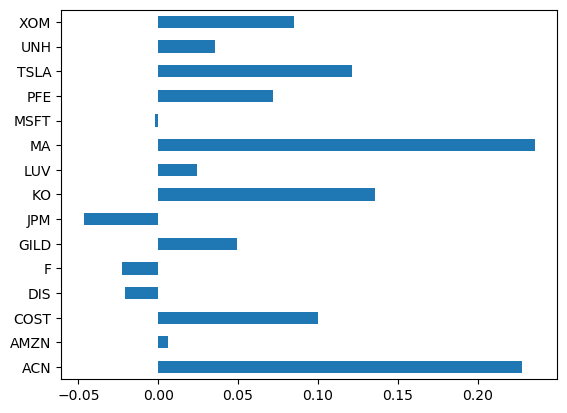

In [69]:
pd.Series(weights).plot.barh();

In [70]:
ef.portfolio_performance(verbose=True)

Annual volatility: 12.2%


(None, 0.12228531551609913, None)

In [71]:
prices

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,0.058398,NaN,NaN,NaN,0.048913,NaN,NaN,NaN,NaN,NaN,NaN,0.097452
1962-01-03,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.047823,NaN,NaN,NaN,NaN,NaN,NaN,0.098900
1962-01-04,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.048187,NaN,NaN,NaN,NaN,NaN,NaN,0.099141
1962-01-05,NaN,NaN,NaN,0.059378,NaN,NaN,NaN,0.047097,NaN,NaN,NaN,NaN,NaN,NaN,0.096970
1962-01-08,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.046613,NaN,NaN,NaN,NaN,NaN,NaN,0.096728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,320.970001,131.690002,555.469971,89.029999,13.42,75.680000,157.179993,61.770000,33.430000,397.070007,336.339996,35.610001,261.070007,504.739990,106.620003
2023-08-02,317.779999,128.210007,552.349976,86.300003,13.04,75.680000,155.399994,61.959999,33.369999,390.019989,327.500000,35.349998,254.110001,504.799988,105.290001
2023-08-03,317.130005,128.910004,557.690002,85.489998,13.10,75.529999,156.350006,61.639999,32.259998,393.010010,326.660004,35.000000,259.320007,504.859985,107.120003


## Let's say we were happy with this portfolio and wanted to actually go out and buy the shares. To do this, we would need to construct a discrete allocation (unless your broker supports fractional shares!)

## If we had $20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:


In [72]:
'''Discreet Allocation'''
class DiscreteAllocation:


    def __init__(
        self, weights, latest_prices, total_portfolio_value=10000, short_ratio=None
    ):

        if not isinstance(weights, dict):
            raise TypeError("weights should be a dictionary of {ticker: weight}")
        if any(np.isnan(val) for val in weights.values()):
            raise ValueError("weights should have no NaNs")
        if (not isinstance(latest_prices, pd.Series)) or any(np.isnan(latest_prices)):
            raise TypeError("latest_prices should be a pd.Series with no NaNs")
        if total_portfolio_value <= 0:
            raise ValueError("total_portfolio_value must be greater than zero")
        if short_ratio is not None and short_ratio < 0:
            raise ValueError("short_ratio must be non-negative")

        # Drop any companies with negligible weights. Use a tuple because order matters.
        self.weights = list(weights.items())
        self.latest_prices = latest_prices
        self.total_portfolio_value = total_portfolio_value
        if short_ratio is None:
            self.short_ratio = sum((-x[1] for x in self.weights if x[1] < 0))
        else:
            self.short_ratio = short_ratio

    @staticmethod
    def _remove_zero_positions(allocation):

        return {k: v for k, v in allocation.items() if v != 0}

    def _allocation_rmse_error(self, verbose=True):

        portfolio_val = 0
        for ticker, num in self.allocation.items():
            portfolio_val += num * self.latest_prices[ticker]

        sse = 0  # sum of square errors
        for ticker, weight in self.weights:
            if ticker in self.allocation:
                allocation_weight = (
                    self.allocation[ticker] * self.latest_prices[ticker] / portfolio_val
                )
            else:
                allocation_weight = 0
            sse += (weight - allocation_weight) ** 2
            if verbose:
                print(
                    "{}: allocated {:.3f}, desired {:.3f}".format(
                        ticker, allocation_weight, weight
                    )
                )
        rmse = np.sqrt(sse / len(self.weights))
        print("Allocation has RMSE: {:.3f}".format(rmse))
        return rmse

    def greedy_portfolio(self, reinvest=False, verbose=False):

        # Sort in descending order of weight
        self.weights.sort(key=lambda x: x[1], reverse=True)

        # If portfolio contains shorts
        if self.weights[-1][1] < 0:
            longs = {t: w for t, w in self.weights if w >= 0}
            shorts = {t: -w for t, w in self.weights if w < 0}

            # Make them sum to one
            long_total_weight = sum(longs.values())
            short_total_weight = sum(shorts.values())
            longs = {t: w / long_total_weight for t, w in longs.items()}
            shorts = {t: w / short_total_weight for t, w in shorts.items()}

            # Construct long-only discrete allocations for each
            short_val = self.total_portfolio_value * self.short_ratio
            long_val = self.total_portfolio_value
            if reinvest:
                long_val += short_val

            if verbose:
                print("\nAllocating long sub-portfolio...")
            da1 = DiscreteAllocation(
                longs, self.latest_prices[longs.keys()], total_portfolio_value=long_val
            )
            long_alloc, long_leftover = da1.greedy_portfolio()

            if verbose:
                print("\nAllocating short sub-portfolio...")
            da2 = DiscreteAllocation(
                shorts,
                self.latest_prices[shorts.keys()],
                total_portfolio_value=short_val,
            )
            short_alloc, short_leftover = da2.greedy_portfolio()
            short_alloc = {t: -w for t, w in short_alloc.items()}

            # Combine and return
            self.allocation = long_alloc.copy()
            self.allocation.update(short_alloc)
            self.allocation = self._remove_zero_positions(self.allocation)

            return self.allocation, long_leftover + short_leftover

        # Otherwise, portfolio is long only and we proceed with greedy algo
        available_funds = self.total_portfolio_value
        shares_bought = []
        buy_prices = []

        # First round
        for ticker, weight in self.weights:
            price = self.latest_prices[ticker]
            # Attempt to buy the lower integer number of shares, which could be zero.
            n_shares = int(weight * self.total_portfolio_value / price)
            cost = n_shares * price
            # As weights are all > 0 (long only) we always round down n_shares
            # so the cost is always <= simple weighted share of portfolio value,
            # so we can not run out of funds just here.
            assert cost <= available_funds, "Unexpectedly insufficient funds."
            available_funds -= cost
            shares_bought.append(n_shares)
            buy_prices.append(price)

        # Second round
        while available_funds > 0:
            # Calculate the equivalent continuous weights of the shares that
            # have already been bought
            current_weights = np.array(buy_prices) * np.array(shares_bought)
            current_weights /= current_weights.sum()
            ideal_weights = np.array([i[1] for i in self.weights])
            deficit = ideal_weights - current_weights

            # Attempt to buy the asset whose current weights deviate the most
            idx = np.argmax(deficit)
            ticker, weight = self.weights[idx]
            price = self.latest_prices[ticker]

            # If we can't afford this asset, search for the next highest deficit that we
            # can purchase.
            counter = 0
            while price > available_funds:
                deficit[idx] = 0  # we can no longer purchase the asset at idx
                idx = np.argmax(deficit)  # find the next most deviant asset

                # If either of these conditions is met, we break out of both while loops
                # hence the repeated statement below
                if deficit[idx] < 0 or counter == 10:
                    break

                ticker, weight = self.weights[idx]
                price = self.latest_prices[ticker]
                counter += 1

            if deficit[idx] <= 0 or counter == 10:  # pragma: no cover
                # Dirty solution to break out of both loops
                break

            # Buy one share at a time
            shares_bought[idx] += 1
            available_funds -= price

        self.allocation = self._remove_zero_positions(
            collections.OrderedDict(zip([i[0] for i in self.weights], shares_bought))
        )

        if verbose:
            print("Funds remaining: {:.2f}".format(available_funds))
            self._allocation_rmse_error(verbose)
        return self.allocation, available_funds

    def lp_portfolio(self, reinvest=False, verbose=False, solver="ECOS_BB"):

        if any([w < 0 for _, w in self.weights]):
            longs = {t: w for t, w in self.weights if w >= 0}
            shorts = {t: -w for t, w in self.weights if w < 0}

            # Make them sum to one
            long_total_weight = sum(longs.values())
            short_total_weight = sum(shorts.values())
            longs = {t: w / long_total_weight for t, w in longs.items()}
            shorts = {t: w / short_total_weight for t, w in shorts.items()}

            # Construct long-only discrete allocations for each
            short_val = self.total_portfolio_value * self.short_ratio
            long_val = self.total_portfolio_value
            if reinvest:
                long_val += short_val

            if verbose:
                print("\nAllocating long sub-portfolio:")
            da1 = DiscreteAllocation(
                longs, self.latest_prices[longs.keys()], total_portfolio_value=long_val
            )
            long_alloc, long_leftover = da1.lp_portfolio(solver=solver)

            if verbose:
                print("\nAllocating short sub-portfolio:")
            da2 = DiscreteAllocation(
                shorts,
                self.latest_prices[shorts.keys()],
                total_portfolio_value=short_val,
            )
            short_alloc, short_leftover = da2.lp_portfolio(solver=solver)
            short_alloc = {t: -w for t, w in short_alloc.items()}

            # Combine and return
            self.allocation = long_alloc.copy()
            self.allocation.update(short_alloc)
            self.allocation = self._remove_zero_positions(self.allocation)
            return self.allocation, long_leftover + short_leftover

        p = self.latest_prices.values
        n = len(p)
        w = np.fromiter([i[1] for i in self.weights], dtype=float)

        # Integer allocation
        x = cp.Variable(n, integer=True)
        # Remaining dollars
        r = self.total_portfolio_value - p.T @ x

        # Set up linear program
        eta = w * self.total_portfolio_value - cp.multiply(x, p)
        u = cp.Variable(n)
        constraints = [eta <= u, eta >= -u, x >= 0, r >= 0]
        objective = cp.sum(u) + r

        opt = cp.Problem(cp.Minimize(objective), constraints)
        opt.solve(solver=solver)

        if opt.status not in {"optimal", "optimal_inaccurate"}:  # pragma: no cover
            raise exceptions.OptimizationError("Please try greedy_portfolio")

        vals = np.rint(x.value).astype(int)
        self.allocation = self._remove_zero_positions(
            collections.OrderedDict(zip([i[0] for i in self.weights], vals))
        )

        if verbose:
            print("Funds remaining: {:.2f}".format(r.value))
            self._allocation_rmse_error()
        return self.allocation, r.value

In [73]:
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $489.19 leftover


/usr/local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'ACN': 13,
 'AMZN': 1,
 'COST': 3,
 'GILD': 11,
 'KO': 41,
 'LUV': 14,
 'MA': 11,
 'PFE': 37,
 'TSLA': 9,
 'UNH': 1,
 'XOM': 14,
 'DIS': -15,
 'F': -115,
 'JPM': -19}

## Max Sharpe with sector constraints

### If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

### In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A sector_mapper, your sector_lower bounds, and your sector_upper bounds.


In [74]:

sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

## We then set up the optimizer and add our constraints. We can use ef.add_objective() to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

    10% of the portfolio in AMZN
    Less than 5% of my portfolio in TSLA



In [75]:
mu = capm_return(prices)
S = CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [76]:
weights

OrderedDict([('ACN', 0.16886),
             ('AMZN', 0.1),
             ('COST', 0.05428),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06456),
             ('JPM', 0.0),
             ('KO', 0.04572),
             ('LUV', 0.02305),
             ('MA', 0.37825),
             ('MSFT', 0.05),
             ('PFE', 0.02844),
             ('TSLA', 0.05),
             ('UNH', 0.03684),
             ('XOM', 0.0)])

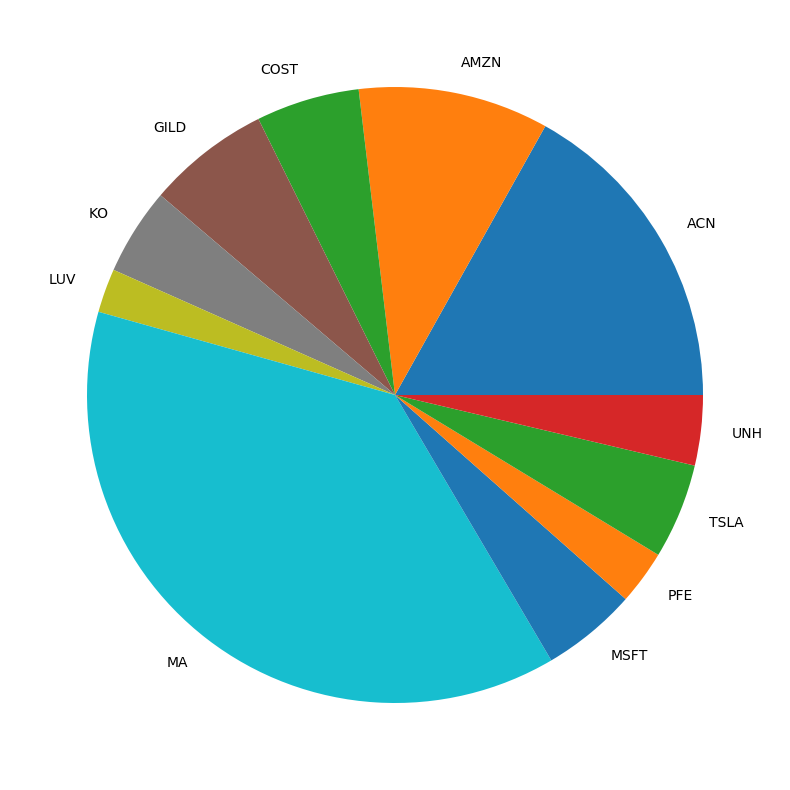

In [77]:
pd.Series(weights).plot.pie(figsize=(10,10));

## We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:

In [78]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Aerospace: 0.023
Auto: 0.050
Consumer Staples: 0.100
Tech: 0.050
Financial Services: 0.378
Healthcare: 0.130
Energy: 0.000
Consumer Discretionary: 0.100
Media: 0.000
Misc: 0.169


## Maximise return for a given risk, with L2 regularisation

### Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).


In [79]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.01015),
             ('AMZN', 0.165),
             ('COST', 0.09355),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06624),
             ('JPM', 0.0),
             ('KO', 0.00645),
             ('LUV', 0.00724),
             ('MA', 0.43722),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.01415),
             ('XOM', 0.0)])

In [80]:
ef.portfolio_performance(verbose=True)

Expected annual return: 26.6%
Annual volatility: 15.0%
Sharpe Ratio: 1.64


(0.26567069874964766, 0.149999999835793, 1.637804660123911)

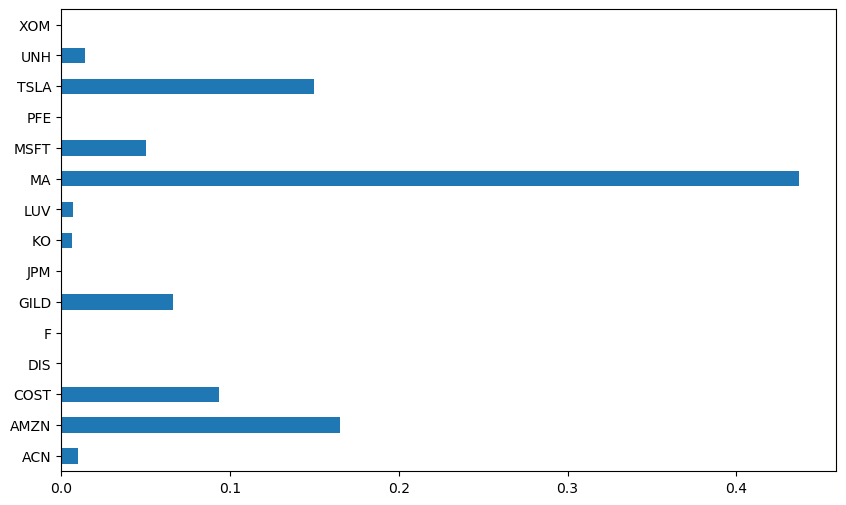

In [81]:
pd.Series(weights).plot.barh(figsize=(10,6))

In [82]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: 1.00


## Efficient semi-variance optimization

### In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

### There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into EfficientFrontier (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).


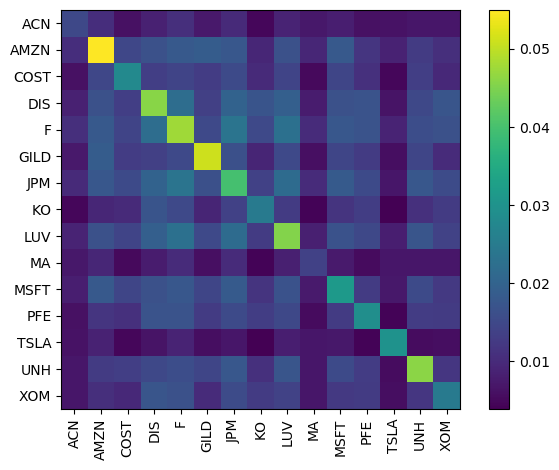

In [83]:
semicov = semicovariance(prices, benchmark=0)
plot_covariance(semicov)

In [84]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.25258),
             ('AMZN', 0.0),
             ('COST', 0.08596),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.01676),
             ('JPM', 0.0),
             ('KO', 0.14705),
             ('LUV', 0.0),
             ('MA', 0.32081),
             ('MSFT', 0.0),
             ('PFE', 0.05),
             ('TSLA', 0.11001),
             ('UNH', 0.00253),
             ('XOM', 0.01429)])

In [85]:
ef.portfolio_performance(verbose=True)

Expected annual return: 21.9%
Annual volatility: 9.3%
Sharpe Ratio: 2.15


(0.2189512414014695, 0.09256257289772761, 2.149370260281018)

### However, this solution is not truly optimal in mean-semivariance space. To do the optimization properly, we must use the EfficientSemivariance class. This requires us to first compute the returns and drop NaNs.

In [86]:
returns = returns_from_prices(prices)
returns = returns.dropna()

In [87]:
'''Efficient Semivariance'''
class EfficientSemivariance(EfficientFrontier):


    def __init__(
        self,
        expected_returns,
        returns,
        frequency=252,
        benchmark=0,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):

        # Instantiate parent
        super().__init__(
            expected_returns=expected_returns,
            cov_matrix=np.zeros((returns.shape[1],) * 2),  # dummy
            weight_bounds=weight_bounds,
            solver=solver,
            verbose=verbose,
            solver_options=solver_options,
        )

        self.returns = self._validate_returns(returns)
        self.benchmark = benchmark
        self.frequency = frequency
        self._T = self.returns.shape[0]

    def min_volatility(self):
        raise NotImplementedError("Please use min_semivariance instead.")

    def max_sharpe(self, risk_free_rate=0.02):
        raise NotImplementedError("Method not available in EfficientSemivariance")

    def min_semivariance(self, market_neutral=False):

        p = cp.Variable(self._T, nonneg=True)
        n = cp.Variable(self._T, nonneg=True)
        self._objective = cp.sum(cp.square(n))

        for obj in self._additional_objectives:
            self._objective += obj

        B = (self.returns.values - self.benchmark) / np.sqrt(self._T)
        self.add_constraint(lambda w: B @ w - p + n == 0)
        self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def max_quadratic_utility(self, risk_aversion=1, market_neutral=False):

        if risk_aversion <= 0:
            raise ValueError("risk aversion coefficient must be greater than zero")

        update_existing_parameter = self.is_parameter_defined("risk_aversion")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("risk_aversion", risk_aversion)
        else:
            p = cp.Variable(self._T, nonneg=True)
            n = cp.Variable(self._T, nonneg=True)
            mu = objective_functions.portfolio_return(self._w, self.expected_returns)
            mu /= self.frequency
            risk_aversion_par = cp.Parameter(
                value=risk_aversion, name="risk_aversion", nonneg=True
            )
            self._objective = mu + 0.5 * risk_aversion_par * cp.sum(cp.square(n))
            for obj in self._additional_objectives:
                self._objective += obj

            B = (self.returns.values - self.benchmark) / np.sqrt(self._T)
            self.add_constraint(lambda w: B @ w - p + n == 0)
            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_risk(self, target_semideviation, market_neutral=False):

        update_existing_parameter = self.is_parameter_defined("target_semivariance")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value(
                "target_semivariance", target_semideviation**2
            )
        else:
            self._objective = objective_functions.portfolio_return(
                self._w, self.expected_returns
            )
            for obj in self._additional_objectives:
                self._objective += obj

            p = cp.Variable(self._T, nonneg=True)
            n = cp.Variable(self._T, nonneg=True)

            target_semivariance = cp.Parameter(
                value=target_semideviation**2, name="target_semivariance", nonneg=True
            )
            self.add_constraint(
                lambda _: self.frequency * cp.sum(cp.square(n)) <= target_semivariance
            )
            B = (self.returns.values - self.benchmark) / np.sqrt(self._T)
            self.add_constraint(lambda w: B @ w - p + n == 0)
            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_return(self, target_return, market_neutral=False):

        if not isinstance(target_return, float) or target_return < 0:
            raise ValueError("target_return should be a positive float")
        if target_return > np.abs(self.expected_returns).max():
            raise ValueError(
                "target_return must be lower than the largest expected return"
            )

        update_existing_parameter = self.is_parameter_defined("target_return")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("target_return", target_return)
        else:
            p = cp.Variable(self._T, nonneg=True)
            n = cp.Variable(self._T, nonneg=True)
            self._objective = cp.sum(cp.square(n))
            for obj in self._additional_objectives:
                self._objective += obj

            target_return_par = cp.Parameter(name="target_return", value=target_return)
            self.add_constraint(
                lambda w: cp.sum(w @ self.expected_returns) >= target_return_par
            )
            B = (self.returns.values - self.benchmark) / np.sqrt(self._T)
            self.add_constraint(lambda w: B @ w - p + n == 0)
            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def portfolio_performance(self, verbose=False, risk_free_rate=0.02):

        mu = portfolio_return(
            self.weights, self.expected_returns, negative=False
        )

        portfolio_returns = self.returns @ self.weights
        drops = np.fmin(portfolio_returns - self.benchmark, 0)
        semivariance = np.sum(np.square(drops)) / self._T * self.frequency
        semi_deviation = np.sqrt(semivariance)
        sortino_ratio = (mu - risk_free_rate) / semi_deviation

        if verbose:
            print("Expected annual return: {:.1f}%".format(100 * mu))
            print("Annual semi-deviation: {:.1f}%".format(100 * semi_deviation))
            print("Sortino Ratio: {:.2f}".format(sortino_ratio))

        return mu, semi_deviation, sortino_ratio

In [88]:
es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True)

Expected annual return: 20.0%
Annual semi-deviation: 10.6%
Sortino Ratio: 1.70


(0.20000010255115822, 0.10591221549921818, 1.6995216434924538)

### To compare this with the heuristic solution, I will use a quick hack: replacing the es.weights with es.weights and running es.portfolio_performance again. Please don't be encouraged to do this in real life!

In [89]:
es.weights = ef.weights
es.portfolio_performance(verbose=True)

Expected annual return: 21.9%
Annual semi-deviation: 13.9%
Sortino Ratio: 1.43


(0.2189512414014695, 0.1386522338121064, 1.4348938775200468)

##### We see that the heuristic method has a significantly lower Sortino ratio, and much higher semivariance.

### Efficient CVaR optimization

#### In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

#### Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.


In [90]:
returns = returns_from_prices(prices).dropna()
returns.head()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2010-06-30,0.000000,0.005985,-0.014381,-0.024768,0.020243,-0.019731,-0.012143,-0.004173,0.000000,-0.017045,-0.012870,-0.001401,-0.002511,-0.008033,-0.003840
2010-07-01,-0.009573,0.015559,0.001276,-0.000317,0.048611,-0.004084,-0.013129,-0.001796,-0.010801,0.016652,0.006518,-0.002104,-0.078473,-0.019366,-0.008060
2010-07-02,-0.008882,-0.016402,-0.012204,-0.003493,-0.027436,0.021382,-0.006929,0.000400,-0.021838,0.000345,0.004750,-0.006325,-0.125683,0.016158,-0.000707
2010-07-06,0.012388,0.008430,-0.004242,0.010835,-0.011673,-0.002868,0.013955,0.007592,-0.011163,-0.013513,0.023636,0.010608,-0.160937,0.020848,0.015733
2010-07-07,0.022130,0.030620,0.005371,0.044767,0.042324,0.004889,0.050096,0.020623,0.062088,0.037694,0.020151,0.023093,-0.019243,0.010730,0.016882


In [91]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True)

Expected annual return: 24.9%
Annual volatility: 13.4%
Sharpe Ratio: 1.72


(0.24915783429888397, 0.13357081120826642, 1.7156280794130707)

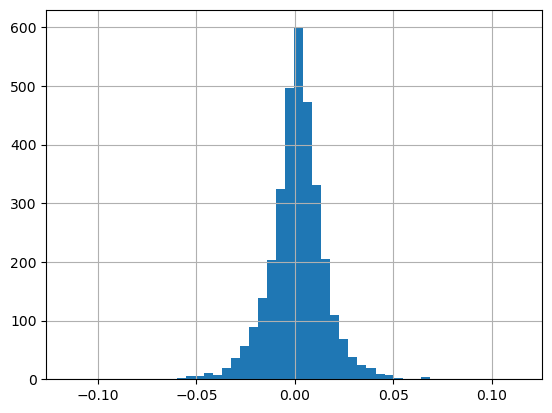

In [92]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50)

In [93]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.23%
CVaR: -3.31%


#### This value of the CVaR means that our average loss on the worst 5% of days will be -3.35%. Let's say that this were beyond our comfort zone (for a $$100,000 portfolio, this would mean losing $3350 in a day).

#### Let's firstly construct the portfolio with the minimum CVaR:

In [94]:
'''Efficient CVaR'''
class EfficientCVaR(EfficientFrontier):


    def __init__(
        self,
        expected_returns,
        returns,
        beta=0.95,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):

        super().__init__(
            expected_returns=expected_returns,
            cov_matrix=np.zeros((returns.shape[1],) * 2),  # dummy
            weight_bounds=weight_bounds,
            solver=solver,
            verbose=verbose,
            solver_options=solver_options,
        )

        self.returns = self._validate_returns(returns)
        self._beta = self._validate_beta(beta)
        self._alpha = cp.Variable()
        self._u = cp.Variable(len(self.returns))

    def set_weights(self, input_weights):
        raise NotImplementedError("Method not available in EfficientCVaR.")

    @staticmethod
    def _validate_beta(beta):
        if not (0 <= beta < 1):
            raise ValueError("beta must be between 0 and 1")
        if beta <= 0.2:
            warnings.warn(
                "Warning: beta is the confidence-level, not the quantile. Typical values are 80%, 90%, 95%.",
                UserWarning,
            )
        return beta

    def min_volatility(self):
        raise NotImplementedError("Please use min_cvar instead.")

    def max_sharpe(self, risk_free_rate=0.02):
        raise NotImplementedError("Method not available in EfficientCVaR.")

    def max_quadratic_utility(self, risk_aversion=1, market_neutral=False):
        raise NotImplementedError("Method not available in EfficientCVaR.")

    def min_cvar(self, market_neutral=False):

        self._objective = self._alpha + 1.0 / (
            len(self.returns) * (1 - self._beta)
        ) * cp.sum(self._u)

        for obj in self._additional_objectives:
            self._objective += obj

        self.add_constraint(lambda _: self._u >= 0.0)
        self.add_constraint(
            lambda w: self.returns.values @ w + self._alpha + self._u >= 0.0
        )

        self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_return(self, target_return, market_neutral=False):

        update_existing_parameter = self.is_parameter_defined("target_return")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("target_return", target_return)
        else:
            self._objective = self._alpha + 1.0 / (
                len(self.returns) * (1 - self._beta)
            ) * cp.sum(self._u)

            for obj in self._additional_objectives:
                self._objective += obj

            self.add_constraint(lambda _: self._u >= 0.0)
            self.add_constraint(
                lambda w: self.returns.values @ w + self._alpha + self._u >= 0.0
            )

            ret = self.expected_returns.T @ self._w
            target_return_par = cp.Parameter(name="target_return", value=target_return)
            self.add_constraint(lambda _: ret >= target_return_par)

            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def efficient_risk(self, target_cvar, market_neutral=False):

        update_existing_parameter = self.is_parameter_defined("target_cvar")
        if update_existing_parameter:
            self._validate_market_neutral(market_neutral)
            self.update_parameter_value("target_cvar", target_cvar)
        else:
            self._objective = portfolio_return(
                self._w, self.expected_returns
            )
            for obj in self._additional_objectives:
                self._objective += obj

            cvar = self._alpha + 1.0 / (len(self.returns) * (1 - self._beta)) * cp.sum(
                self._u
            )
            target_cvar_par = cp.Parameter(
                value=target_cvar, name="target_cvar", nonneg=True
            )

            self.add_constraint(lambda _: cvar <= target_cvar_par)
            self.add_constraint(lambda _: self._u >= 0.0)
            self.add_constraint(
                lambda w: self.returns.values @ w + self._alpha + self._u >= 0.0
            )

            self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

    def portfolio_performance(self, verbose=False):

        mu = portfolio_return(
            self.weights, self.expected_returns, negative=False
        )

        cvar = self._alpha + 1.0 / (len(self.returns) * (1 - self._beta)) * cp.sum(
            self._u
        )
        cvar_val = cvar.value

        if verbose:
            print("Expected annual return: {:.1f}%".format(100 * mu))
            print("Conditional Value at Risk: {:.2f}%".format(100 * cvar_val))

        return mu, cvar_val

In [95]:
ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True)

Expected annual return: 17.2%
Conditional Value at Risk: 2.15%


(0.17226719621463116, 0.021464740099831143)

#### We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use efficient_risk to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [96]:
ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True)

Expected annual return: 23.4%
Conditional Value at Risk: 2.50%


(0.23372406980993266, 0.025000000000003235)

#### We now have similar returns to before (24.7% vs 25.8%), but with a lower tail risk (2.50% CVaR vs 3.35%).

## Plotting - Unconstrained

#### To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm.

In [97]:
'''CLA'''
class CLA(BaseOptimizer):


    def __init__(self, expected_returns, cov_matrix, weight_bounds=(0, 1)):

        # Initialize the class
        self.mean = np.array(expected_returns).reshape((len(expected_returns), 1))
        # if (self.mean == np.ones(self.mean.shape) * self.mean.mean()).all():
        #     self.mean[-1, 0] += 1e-5
        self.expected_returns = self.mean.reshape((len(self.mean),))
        self.cov_matrix = np.asarray(cov_matrix)

        # Bounds
        if len(weight_bounds) == len(self.mean) and not isinstance(
            weight_bounds[0], (float, int)
        ):
            self.lB = np.array([b[0] for b in weight_bounds]).reshape(-1, 1)
            self.uB = np.array([b[1] for b in weight_bounds]).reshape(-1, 1)
        else:
            if isinstance(weight_bounds[0], (float, int)):
                self.lB = np.ones(self.mean.shape) * weight_bounds[0]
            else:
                self.lB = np.array(weight_bounds[0]).reshape(self.mean.shape)
            if isinstance(weight_bounds[0], (float, int)):
                self.uB = np.ones(self.mean.shape) * weight_bounds[1]
            else:
                self.uB = np.array(weight_bounds[1]).reshape(self.mean.shape)

        self.w = []  # solution
        self.ls = []  # lambdas
        self.g = []  # gammas
        self.f = []  # free weights

        self.frontier_values = None  # result of computing efficient frontier

        if isinstance(expected_returns, pd.Series):
            tickers = list(expected_returns.index)
        else:
            tickers = list(range(len(self.mean)))
        super().__init__(len(tickers), tickers)

    @staticmethod
    def _infnone(x):

        return float("-inf") if x is None else x

    def _init_algo(self):
        # Initialize the algo
        # 1) Form structured array
        a = np.zeros((self.mean.shape[0]), dtype=[("id", int), ("mu", float)])
        b = [self.mean[i][0] for i in range(self.mean.shape[0])]  # dump array into list
        # fill structured array
        a[:] = list(zip(list(range(self.mean.shape[0])), b))
        # 2) Sort structured array
        b = np.sort(a, order="mu")
        # 3) First free weight
        i, w = b.shape[0], np.copy(self.lB)
        while sum(w) < 1:
            i -= 1
            w[b[i][0]] = self.uB[b[i][0]]
        w[b[i][0]] += 1 - sum(w)
        return [b[i][0]], w

    def _compute_bi(self, c, bi):
        if c > 0:
            bi = bi[1][0]
        if c < 0:
            bi = bi[0][0]
        return bi

    def _compute_w(self, covarF_inv, covarFB, meanF, wB):
        # 1) compute gamma
        onesF = np.ones(meanF.shape)
        g1 = np.dot(np.dot(onesF.T, covarF_inv), meanF)
        g2 = np.dot(np.dot(onesF.T, covarF_inv), onesF)
        if wB is None:
            g, w1 = float(-self.ls[-1] * g1 / g2 + 1 / g2), 0
        else:
            onesB = np.ones(wB.shape)
            g3 = np.dot(onesB.T, wB)
            g4 = np.dot(covarF_inv, covarFB)
            w1 = np.dot(g4, wB)
            g4 = np.dot(onesF.T, w1)
            g = float(-self.ls[-1] * g1 / g2 + (1 - g3 + g4) / g2)
        # 2) compute weights
        w2 = np.dot(covarF_inv, onesF)
        w3 = np.dot(covarF_inv, meanF)
        return -w1 + g * w2 + self.ls[-1] * w3, g

    def _compute_lambda(self, covarF_inv, covarFB, meanF, wB, i, bi):
        # 1) C
        onesF = np.ones(meanF.shape)
        c1 = np.dot(np.dot(onesF.T, covarF_inv), onesF)
        c2 = np.dot(covarF_inv, meanF)
        c3 = np.dot(np.dot(onesF.T, covarF_inv), meanF)
        c4 = np.dot(covarF_inv, onesF)
        c = -c1 * c2[i] + c3 * c4[i]
        if c == 0:  # pragma: no cover
            return None, None
        # 2) bi
        if type(bi) == list:
            bi = self._compute_bi(c, bi)
        # 3) Lambda
        if wB is None:
            # All free assets
            return float((c4[i] - c1 * bi) / c), bi
        else:
            onesB = np.ones(wB.shape)
            l1 = np.dot(onesB.T, wB)
            l2 = np.dot(covarF_inv, covarFB)
            l3 = np.dot(l2, wB)
            l2 = np.dot(onesF.T, l3)
            return float(((1 - l1 + l2) * c4[i] - c1 * (bi + l3[i])) / c), bi

    def _get_matrices(self, f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF = self._reduce_matrix(self.cov_matrix, f, f)
        meanF = self._reduce_matrix(self.mean, f, [0])
        b = self._get_b(f)
        covarFB = self._reduce_matrix(self.cov_matrix, f, b)
        wB = self._reduce_matrix(self.w[-1], b, [0])
        return covarF, covarFB, meanF, wB

    def _get_b(self, f):
        return self._diff_lists(list(range(self.mean.shape[0])), f)

    @staticmethod
    def _diff_lists(list1, list2):
        return list(set(list1) - set(list2))

    @staticmethod
    def _reduce_matrix(matrix, listX, listY):
        # Reduce a matrix to the provided list of rows and columns
        if len(listX) == 0 or len(listY) == 0:
            return
        matrix_ = matrix[:, listY[0] : listY[0] + 1]
        for i in listY[1:]:
            a = matrix[:, i : i + 1]
            matrix_ = np.append(matrix_, a, 1)
        matrix__ = matrix_[listX[0] : listX[0] + 1, :]
        for i in listX[1:]:
            a = matrix_[i : i + 1, :]
            matrix__ = np.append(matrix__, a, 0)
        return matrix__

    def _purge_num_err(self, tol):
        # Purge violations of inequality constraints (associated with ill-conditioned cov matrix)
        i = 0
        while True:
            flag = False
            if i == len(self.w):
                break
            if abs(sum(self.w[i]) - 1) > tol:
                flag = True
            else:
                for j in range(self.w[i].shape[0]):
                    if (
                        self.w[i][j] - self.lB[j] < -tol
                        or self.w[i][j] - self.uB[j] > tol
                    ):  # pragma: no cover
                        flag = True
                        break
            if flag is True:
                del self.w[i]
                del self.ls[i]
                del self.g[i]
                del self.f[i]
            else:
                i += 1

    def _purge_excess(self):
        # Remove violations of the convex hull
        i, repeat = 0, False
        while True:
            if repeat is False:
                i += 1
            if i == len(self.w) - 1:
                break
            w = self.w[i]
            mu = np.dot(w.T, self.mean)[0, 0]
            j, repeat = i + 1, False
            while True:
                if j == len(self.w):
                    break
                w = self.w[j]
                mu_ = np.dot(w.T, self.mean)[0, 0]
                if mu < mu_:
                    del self.w[i]
                    del self.ls[i]
                    del self.g[i]
                    del self.f[i]
                    repeat = True
                    break
                else:
                    j += 1

    def _golden_section(self, obj, a, b, **kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed
        tol, sign, args = 1.0e-9, 1, None
        if "minimum" in kargs and kargs["minimum"] is False:
            sign = -1
        if "args" in kargs:
            args = kargs["args"]
        numIter = int(np.ceil(-2.078087 * np.log(tol / abs(b - a))))
        r = 0.618033989
        c = 1.0 - r
        # Initialize
        x1 = r * a + c * b
        x2 = c * a + r * b
        f1 = sign * obj(x1, *args)
        f2 = sign * obj(x2, *args)
        # Loop
        for i in range(numIter):
            if f1 > f2:
                a = x1
                x1 = x2
                f1 = f2
                x2 = c * a + r * b
                f2 = sign * obj(x2, *args)
            else:
                b = x2
                x2 = x1
                f2 = f1
                x1 = r * a + c * b
                f1 = sign * obj(x1, *args)
        if f1 < f2:
            return x1, sign * f1
        else:
            return x2, sign * f2

    def _eval_sr(self, a, w0, w1):
        # Evaluate SR of the portfolio within the convex combination
        w = a * w0 + (1 - a) * w1
        b = np.dot(w.T, self.mean)[0, 0]
        c = np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5
        return b / c

    def _solve(self):
        # Compute the turning points,free sets and weights
        f, w = self._init_algo()
        self.w.append(np.copy(w))  # store solution
        self.ls.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            # 1) case a): Bound one free weight
            l_in = None
            if len(f) > 1:
                covarF, covarFB, meanF, wB = self._get_matrices(f)
                covarF_inv = np.linalg.inv(covarF)
                j = 0
                for i in f:
                    l, bi = self._compute_lambda(
                        covarF_inv, covarFB, meanF, wB, j, [self.lB[i], self.uB[i]]
                    )
                    if CLA._infnone(l) > CLA._infnone(l_in):
                        l_in, i_in, bi_in = l, i, bi
                    j += 1
            # 2) case b): Free one bounded weight
            l_out = None
            if len(f) < self.mean.shape[0]:
                b = self._get_b(f)
                for i in b:
                    covarF, covarFB, meanF, wB = self._get_matrices(f + [i])
                    covarF_inv = np.linalg.inv(covarF)
                    l, bi = self._compute_lambda(
                        covarF_inv,
                        covarFB,
                        meanF,
                        wB,
                        meanF.shape[0] - 1,
                        self.w[-1][i],
                    )
                    if (self.ls[-1] is None or l < self.ls[-1]) and l > CLA._infnone(
                        l_out
                    ):
                        l_out, i_out = l, i
            if (l_in is None or l_in < 0) and (l_out is None or l_out < 0):
                # 3) compute minimum variance solution
                self.ls.append(0)
                covarF, covarFB, meanF, wB = self._get_matrices(f)
                covarF_inv = np.linalg.inv(covarF)
                meanF = np.zeros(meanF.shape)
            else:
                # 4) decide lambda
                if CLA._infnone(l_in) > CLA._infnone(l_out):
                    self.ls.append(l_in)
                    f.remove(i_in)
                    w[i_in] = bi_in  # set value at the correct boundary
                else:
                    self.ls.append(l_out)
                    f.append(i_out)
                covarF, covarFB, meanF, wB = self._get_matrices(f)
                covarF_inv = np.linalg.inv(covarF)
            # 5) compute solution vector
            wF, g = self._compute_w(covarF_inv, covarFB, meanF, wB)
            for i in range(len(f)):
                w[f[i]] = wF[i]
            self.w.append(np.copy(w))  # store solution
            self.g.append(g)
            self.f.append(f[:])
            if self.ls[-1] == 0:
                break
        # 6) Purge turning points
        self._purge_num_err(10e-10)
        self._purge_excess()

    def max_sharpe(self):

        if not self.w:
            self._solve()
        # 1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr, sr = [], []
        for i in range(len(self.w) - 1):
            w0 = np.copy(self.w[i])
            w1 = np.copy(self.w[i + 1])
            kargs = {"minimum": False, "args": (w0, w1)}
            a, b = self._golden_section(self._eval_sr, 0, 1, **kargs)
            w_sr.append(a * w0 + (1 - a) * w1)
            sr.append(b)

        self.weights = w_sr[sr.index(max(sr))].reshape((self.n_assets,))
        return self._make_output_weights()

    def min_volatility(self):

        if not self.w:
            self._solve()
        var = []
        for w in self.w:
            a = np.dot(np.dot(w.T, self.cov_matrix), w)
            var.append(a)
        # return min(var)**.5, self.w[var.index(min(var))]
        self.weights = self.w[var.index(min(var))].reshape((self.n_assets,))
        return self._make_output_weights()

    def efficient_frontier(self, points=100):

        if not self.w:
            self._solve()

        mu, sigma, weights = [], [], []
        # remove the 1, to avoid duplications
        a = np.linspace(0, 1, points // len(self.w))[:-1]
        b = list(range(len(self.w) - 1))
        for i in b:
            w0, w1 = self.w[i], self.w[i + 1]
            if i == b[-1]:
                # include the 1 in the last iteration
                a = np.linspace(0, 1, points // len(self.w))
            for j in a:
                w = w1 * j + (1 - j) * w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T, self.mean)[0, 0])
                sigma.append(np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5)

        self.frontier_values = (mu, sigma, weights)
        return mu, sigma, weights

    def set_weights(self, _):
        # Overrides parent method since set_weights does nothing.
        raise NotImplementedError("set_weights does nothing for CLA")

    def portfolio_performance(self, verbose=False, risk_free_rate=0.02):

        return portfolio_performance(
            self.weights,
            self.expected_returns,
            self.cov_matrix,
            verbose,
            risk_free_rate,
        )

In [98]:
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

Expected annual return: 24.6%
Annual volatility: 13.2%
Sharpe Ratio: 1.71


/tmp/ipykernel_806/3433844386.py:114: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(((1 - l1 + l2) * c4[i] - c1 * (bi + l3[i])) / c), bi
/tmp/ipykernel_806/3433844386.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g = float(-self.ls[-1] * g1 / g2 + (1 - g3 + g4) / g2)


(0.24629839238346973, 0.1319709850653917, 1.714758681776443)

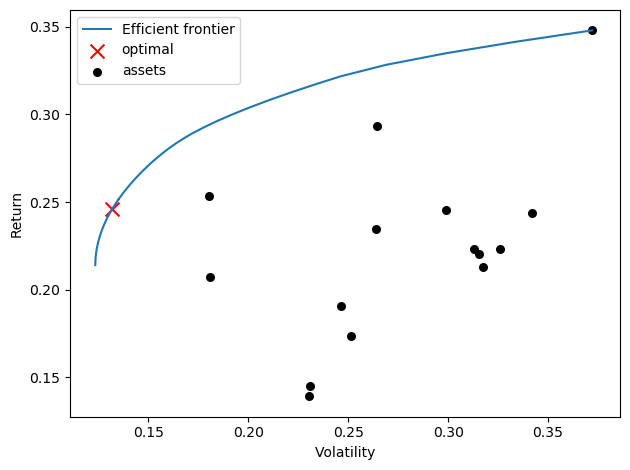

In [99]:
ax = plot_efficient_frontier(cla, showfig=False)

## Plotting - Constrained

#### In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to MSFT, AMZN, and TSLA (e.g maybe we want to avoid big tech).

In [100]:
mu = capm_return(prices)
S = CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "TSLA"} for t in tickers]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

### As per the docs, before we call any optimization function, we should pass this to the plotting module:

In [101]:
'''exceptions'''
class OptimizationError(Exception):
    """
    When an optimization routine fails – usually, this means
    that cvxpy has not returned the "optimal" flag.
    """

    def __init__(self, *args, **kwargs):
        default_message = (
            "Please check your objectives/constraints or use a different solver."
        )
        super().__init__(default_message, *args, **kwargs)


class InstantiationError(Exception):
    """
    Errors related to the instantiation of pypfopt objects, e.g adding constraints to an
    already-solved problem
    """

    pass

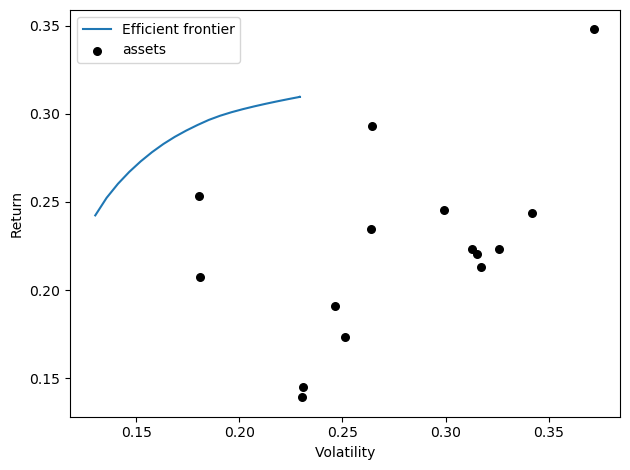

In [102]:
ax = plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.13, 0.4, 50), 
                                      showfig=False)

## Complex plots

#### The plotting module allows you to pass in an ax, on top of which the plots are added. This allows you to build complex plots.

#### In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios.

#### To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):


In [103]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.22120213 0.21579789 0.2200408  ... 0.20038376 0.21985011 0.20311157]
Sample portfolio volatilities: 0       0.141952
1       0.161131
2       0.153603
3       0.163817
4       0.156367
          ...   
9995    0.158998
9996    0.150298
9997    0.154552
9998    0.160728
9999    0.145534
Length: 10000, dtype: float64


##### Note that the above code is equivalent to generating samples via a for loop (just more efficient)

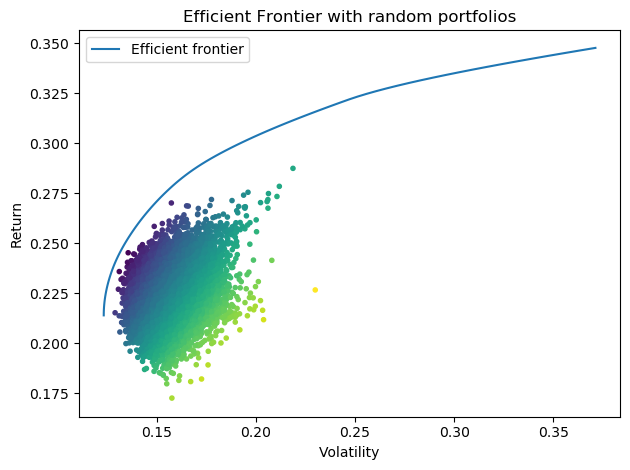

In [104]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()